In [19]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
import numpy as np


In [20]:

# --- 1. CONFIGURATION ---
class Config:
    """Configuration settings for testing."""
    DATA_ROOT = './MNIST-Data'
    MODEL_LOAD_PATH = 'best_mnist_cnn.pth'
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    BATCH_SIZE = 64
    SAMPLE_GRID_SIZE = 5 # Display a 5x5 grid of samples


In [21]:

# --- 2. MODEL DEFINITION (Must match the trained model exactly) ---
class SimpleCNN(nn.Module):
    """
    The exact CNN architecture used for training the model.
    """
    def __init__(self):
        super().__init__()
        # Layer 1: Conv (1->16 channels, 28x28 output), ReLU, Pool (16x14x14 output)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1) 
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Layer 2: Conv (16->32 channels, 14x14 output), ReLU, Pool (32x7x7 output)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        
        # Layer 3: Fully Connected (32*7*7 inputs, 10 outputs)
        self.fc1 = nn.Linear(32 * 7 * 7, 10)

        #layer 3 : fully connected layer (10 -> 10 classes)
        self.fc2 = nn.Linear(10, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7) 
        x = self.fc1(x)
        x = self.fc2(x)
        return x


In [22]:

# --- 3. DATA LOADING & TRANSFORMS ---
# Transformations MUST match the training phase's normalization
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) 
])

# Load the test dataset (with normalization for model input)
test_dataset = MNIST(root=Config.DATA_ROOT, train=False, download=True, transform=transform)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=Config.BATCH_SIZE,
    shuffle=False,
    num_workers=os.cpu_count() or 0
)

# Load the raw test dataset (without normalization for visualization)
test_dataset_raw = MNIST(root=Config.DATA_ROOT, train=False, download=True, transform=transforms.ToTensor())



In [23]:

# --- 4. MODEL LOADING AND SETUP ---
def load_pretrained_model():
    """Initializes the model and loads the state dictionary from the .pth file."""
    model = SimpleCNN().to(Config.DEVICE)
    if not os.path.exists(Config.MODEL_LOAD_PATH):
        raise FileNotFoundError(
            f"Error: Model file not found at {Config.MODEL_LOAD_PATH}. "
            "Please ensure the file is in the current directory."
        )
    
    # Load the saved state dictionary
    model.load_state_dict(torch.load(Config.MODEL_LOAD_PATH, map_location=Config.DEVICE))
    model.eval() # Set the model to evaluation mode
    print(f"Model successfully loaded from {Config.MODEL_LOAD_PATH}.")
    return model


In [24]:


# --- 5. VISUALIZATION AND PREDICTION ---
def visualize_and_test(model, raw_dataset, device, grid_size):
    """Plots sample images and shows the model's prediction vs. the true label."""
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(12, 12))
    plt.suptitle(f"Model Predictions (Loaded from {Config.MODEL_LOAD_PATH})", fontsize=16)

    axes = axes.flatten()
    num_samples = grid_size * grid_size
    
    # Select random indices
    indices = np.random.choice(len(raw_dataset), num_samples, replace=False)

    # Use the test_dataset (normalized) for model input
    # Use the raw_dataset (un-normalized) for plotting
    
    with torch.no_grad():
        for i, idx in enumerate(indices):
            # 1. Get raw image and label for plotting
            image_tensor_raw, true_label = raw_dataset[idx] 
            image_np = image_tensor_raw.squeeze().numpy()
            
            # 2. Get normalized image for model prediction
            # The test_dataset uses the correct normalization transform
            image_tensor_norm, _ = test_dataset[idx] 
            
            # 3. Get model prediction
            # Add a batch dimension (1 x C x H x W)
            input_data = image_tensor_norm.unsqueeze(0).to(device)
            output = model(input_data)
            predicted_label = output.argmax(dim=1).item()

            # 4. Plotting
            ax = axes[i]
            ax.imshow(image_np, cmap='gray')
            
            color = 'green' if predicted_label == true_label else 'red'
            ax.set_title(f"True: {true_label} | Pred: {predicted_label}", 
                         color=color, fontsize=10)
            ax.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()



Model successfully loaded from best_mnist_cnn.pth.
Testing model on sample data...


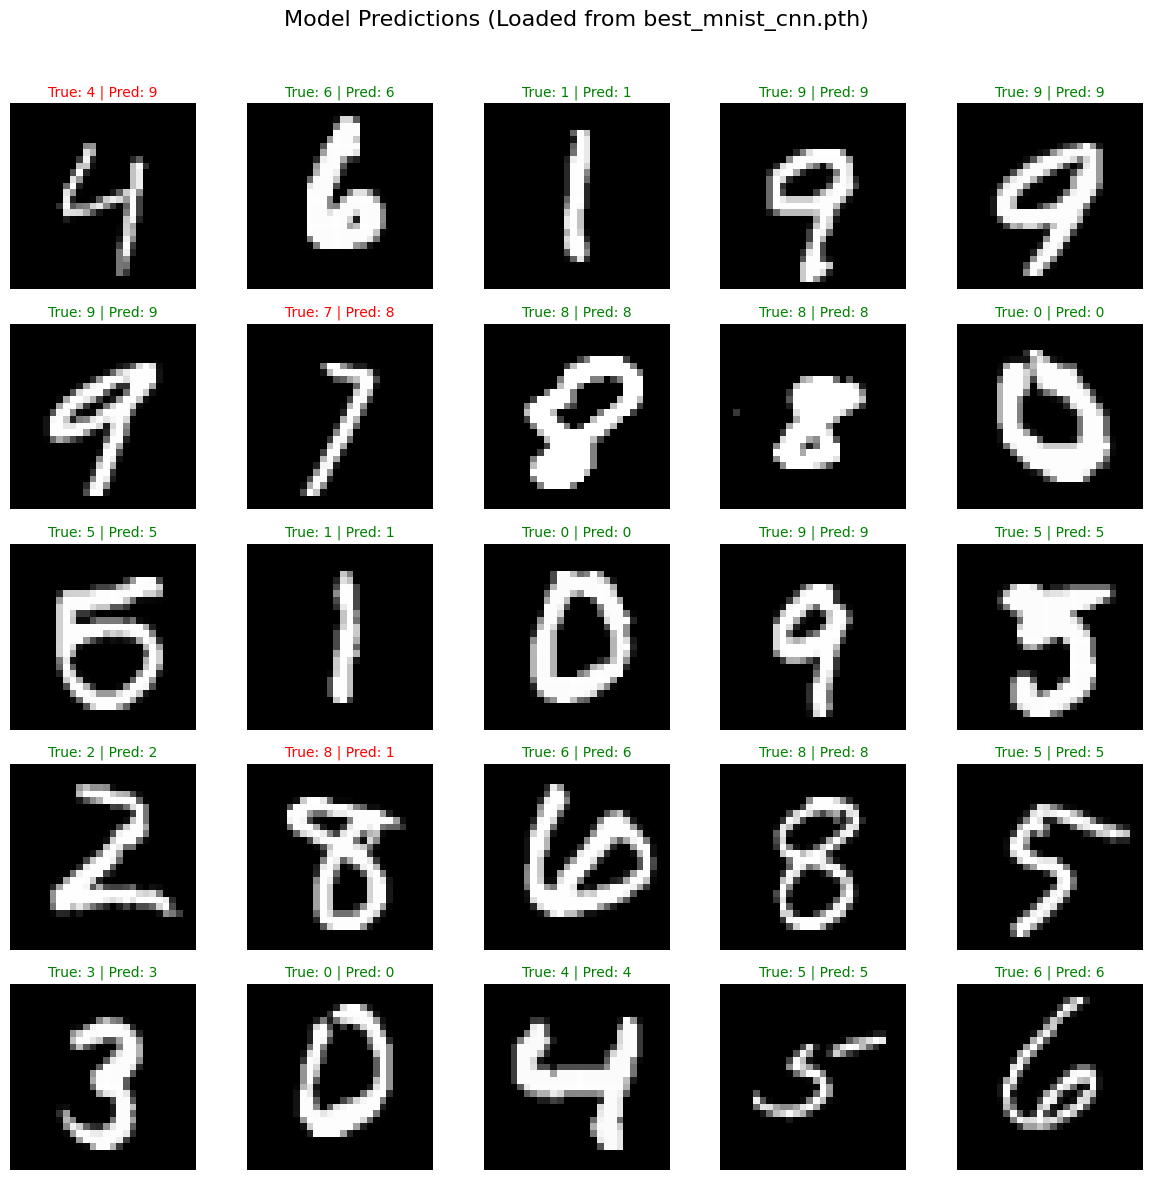


To calculate the overall test accuracy, you would run a full evaluation loop...


In [25]:

# --- 6. MAIN EXECUTION ---

pretrained_model = load_pretrained_model()

# Visualize and Test
print("Testing model on sample data...")
visualize_and_test(pretrained_model, test_dataset_raw, Config.DEVICE, Config.SAMPLE_GRID_SIZE)

# You can also run a full evaluation if needed
print("\nTo calculate the overall test accuracy, you would run a full evaluation loop...")




## How to Run This Script

1.  **Save the Code:** Save the code above as a new file named **`test_model.py`** in your project's root folder (`MNIST CLASSIFIER`).
2.  **Ensure Files Exist:** Make sure **`best_mnist_cnn.pth`** and the **`MNIST-Data`** folder are present in the same location.
3.  **Execute:** Run the script from your terminal:
    ```bash
    python test_model.py
    ```

The script will:
* Load the saved weights into the `SimpleCNN` structure.
* Generate a grid of **25 (5x5)** random images from the test set.
* Run each image through the loaded model to get a prediction.
* Display the **True Label** and the **Predicted Label** on the image title, coloring it **green** for correct predictions and **red** for incorrect ones.
````

In [17]:
from rich import print as rprint

state_dict = torch.load("best_mnist_cnn.pth")
rprint(state_dict.keys())

odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 
'fc2.bias'])

In [18]:
for k, v in state_dict.items():
    print(k, v.shape)


conv1.weight torch.Size([16, 1, 3, 3])
conv1.bias torch.Size([16])
conv2.weight torch.Size([32, 16, 3, 3])
conv2.bias torch.Size([32])
fc1.weight torch.Size([10, 1568])
fc1.bias torch.Size([10])
fc2.weight torch.Size([10, 10])
fc2.bias torch.Size([10])
